In [6]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512 
tau_sim = 1.5     
DTS = 8     

# Glasma for Pb-Pb at 5.02 TeV
# su_group = 'su3'
# A = 207     
# sqrts = 5020        
# ns = 50     
# factor = 0.8        
# Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)        
# g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          
# mu = Qs / (g**2 * factor)          	
# ir = 0.1 * g**2 * mu         
# uv = 10.0         

# Glasma
su_group = 'su3'
Qs = 2.0        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g2mu         
uv = 10.0 

# Wong
quark = 'charm'    
mass = 1.275       
tau_form = 1/(2*mass)*hbarc

tau_sim += tau_form

# tau_form = 0
initialization = 'fonll'         
ntp = 10**5  

nevents_offset = 5
nevents = 20    

representation = 'fundamental'      
boundary = 'periodic'   

# Results folder
folder = 'RAA_' + quark + '_fonll_Qs_' + str(Qs)

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,   
    'NTP':  ntp,  
    'FOLDER': folder,             
    }

In [7]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.WONG_TO_HOST = True
from curraun.wong import init_pos, init_charge, init_mom_toy, init_mom_fonll
from curraun.particles_correlators import TransMom

In [8]:
import pickle
from tqdm import tqdm

current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'

In [9]:
def simulate(p, ev): 
    os.chdir(results_path)

    output = {}
    output['parameters'] = p.copy()

    # Derived parameters
    a = L/N
    E0 = N/L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # fonll
    pTs_fonll, ntp_fonll = init_mom_fonll(p)
    ntp = ntp_fonll

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        # fonll
        pT = pTs_fonll[i] / E0
        p0 = init_mom_toy('pT', pT)

        p0s[i, :] = np.array(p0, dtype=object)

        x0, q0 = init_pos(s.n), init_charge(representation)
        x0s[i, :], q0s[i, :] = x0, q0
    
    wong_solver.initialize(x0s, p0s, q0s, masses)

    pTs = np.zeros((maxt-formt, ntp))
    compute_pT = TransMom(wong_solver, ntp)

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                compute_pT.compute()
                pTs[t-formt] = compute_pT.pT.copy() * E0
                
                wong_solver.evolve()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    tau = np.linspace(0, tau_sim-p['TFORM'], maxt-formt)
    output['tau'], output['pTs'] = tau, pTs
    output["pTs_fonll"], output["ntp_fonl"] = pTs_fonll, ntp_fonll

    wong_folder = p['FOLDER']
    if not os.path.isdir(wong_folder):
        os.makedirs(wong_folder)
    wong_path = results_path + '/' + wong_folder + '/'
    os.chdir(wong_path)

    filename = 'event_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)
    return output

In [6]:
pTs_fonll, ntp_fonll = init_mom_fonll(p)

In [5]:
import matplotlib.pyplot as plt
plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["text.usetex"] = False

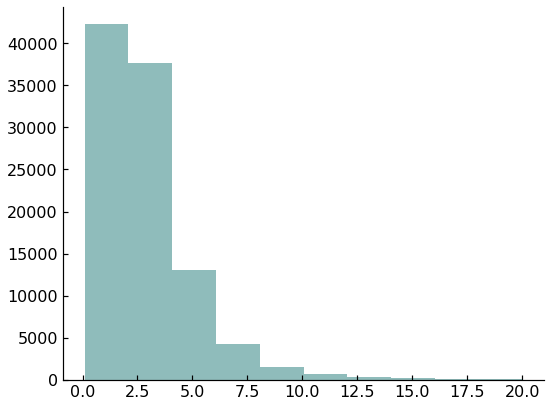

In [10]:
plt.hist(pTs_fonll)
plt.tight_layout()

In [12]:
import seaborn as sns

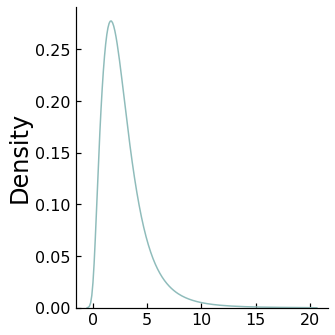

In [16]:
sns.displot(pTs_fonll, kind="kde")

In [10]:
# quarks = ['jet']
# quark_masses = [1]
# pTs = [100]
# formation_times = [0]

# quarks = ['beauty']
# quark_masses = [4.18]
# pTs = [2]
# formation_times = [0.02]

quarks = [quark]
quark_masses = [mass]
formation_times = [tau_form]

for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = formation_times[iq]

    for ev in range(nevents_offset, nevents+nevents_offset):
        simulate(p, ev)

Charm quark


Event 9:  61%|██████    | 393/646 [01:34<01:02,  4.03it/s]